In [23]:
# Importing necessary libraries for single-cell RNA analysis, probabilistic modeling, and CNV inference.
import scanpy as sc  # For single-cell RNA-seq data analysis.
import scvi  # For probabilistic modeling of single-cell data.
import pandas as pd  # For data manipulation and analysis with DataFrames.
import infercnvpy as cnv  # For inferring copy number variations in single-cell RNA-seq data.
import matplotlib.pyplot as plt  # For data visualization.


In [2]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"


In [3]:
# Loading the previously saved AnnData object that contains CellTypist annotations and other analysis results.
adata = sc.read_h5ad(f'{base_data_path}/cell_typist_annotated.h5ad')

# Displaying the loaded AnnData object for verification.
adata


AnnData object with n_obs × n_vars = 73580 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score_sig', 'cell_type'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [6]:
# Loading the pre-trained SCVI model from the specified path and associating it with the loaded AnnData object for further analysis.
model = scvi.model.SCVI.load(f'{base_data_path}/model.model', adata)


INFO     File /Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data/model.model/model.pt already downloaded          


In [8]:
# Loading the gene annotation information from the 'hg38__gencode_v27.txt' file, using tab as a separator.
# The file contains information on genes for the hg38 genome version.
gene_info = pd.read_csv(f'{base_data_path}/hg38__gencode_v27.txt', sep='\t', header=None)

# Displaying the first few rows of the gene annotation data for inspection.
gene_info.head()


,0,1,2,3
0,DDX11L1,chr1,11869,14409
1,WASH7P,chr1,14404,29570
2,MIR6859-1,chr1,17369,17436
3,MIR1302-2HG,chr1,29554,31109
4,MIR1302-2,chr1,30366,30503


In [9]:
# Renaming the columns of the gene_info DataFrame to provide meaningful labels:
# 'gene_symbol', 'chromosome', 'start', and 'end' for easier reference.
gene_info.columns = ['gene_symbol', 'chromosome', 'start', 'end']

# Displaying the first few rows of the updated gene_info DataFrame to verify the new column names.
gene_info.head()


,gene_symbol,chromosome,start,end
0,DDX11L1,chr1,11869,14409
1,WASH7P,chr1,14404,29570
2,MIR6859-1,chr1,17369,17436
3,MIR1302-2HG,chr1,29554,31109
4,MIR1302-2,chr1,30366,30503


In [10]:
# Assigning the gene names from the AnnData object's variable names to a new column 'gene_symbol' in the var DataFrame.
# This helps to keep track of the gene symbols associated with each variable (gene) in the dataset.
adata.var['gene_symbol'] = adata.var_names

# Displaying the updated variable DataFrame to verify the addition of the 'gene_symbol' column.
adata.var


,n_cells,gene_symbol
AL627309.1,91,AL627309.1
AL627309.3,14,AL627309.3
AL627309.5,725,AL627309.5
AL627309.4,24,AL627309.4
AP006222.2,21,AP006222.2
...,...,...
AC233755.2,25,AC233755.2
AC233755.1,36,AC233755.1
AC141272.1,11,AC141272.1
AC007325.4,274,AC007325.4


In [11]:
# Merging the gene_info DataFrame with the AnnData object's var DataFrame on the 'gene_symbol' column.
# This operation adds additional gene annotation information (chromosome, start, end) to the var DataFrame in the AnnData object.
adata.var = adata.var.merge(gene_info, on='gene_symbol', how='left')

# Setting 'gene_symbol' as the index for the var DataFrame to facilitate easier access to gene-specific information.
adata.var.set_index('gene_symbol', inplace=True)

# Displaying the updated var DataFrame to verify the merge and the new index setting.
adata.var


,n_cells,chromosome,start,end
gene_symbol,,,,
AL627309.1,91,chr1,89295.0,133723.0
AL627309.3,14,chr1,89551.0,91105.0
AL627309.5,725,chr1,141474.0,173862.0
AL627309.4,24,chr1,160446.0,161525.0
AP006222.2,21,NaN,NaN,NaN
...,...,...,...,...
AC233755.2,25,NaN,NaN,NaN
AC233755.1,36,NaN,NaN,NaN
AC141272.1,11,NaN,NaN,NaN


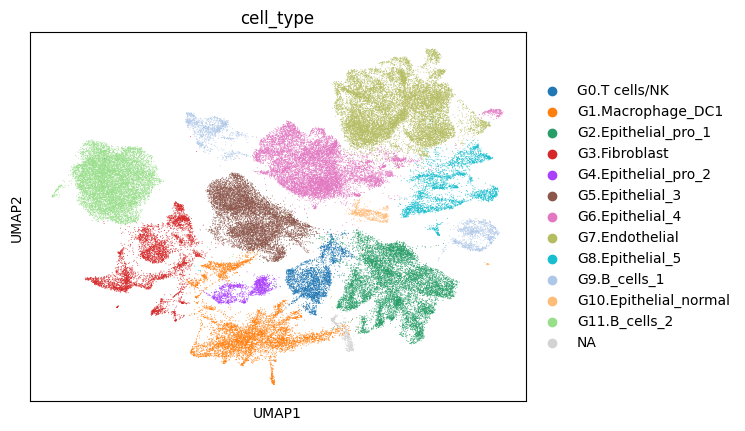

In [12]:
# Plotting the UMAP visualization, coloring cells based on their assigned cell types from the 'cell_type' column in the AnnData object.
sc.pl.umap(adata, color="cell_type")


In [15]:
# Extracting the unique cell types from the 'cell_type' column in the AnnData object's observations to see the distinct categories present.
unique_cell_types = set(adata.obs["cell_type"])


In [16]:
# Defining a list of normal cell types that will be used as a reference for CNV analysis or comparison.
normal_cell_types = ['G0.T cells/NK', "G1.Macrophage_DC1", "G3.Fibroblast", 'G7.Endothelial', "G9.B_cells_1", "G11.B_cells_2"]


In [17]:
# Inferring copy number variations (CNVs) using InferCNV on the AnnData object.
# All immune cell types are provided as "normal cells" for comparison.
# The analysis uses the 'cell_type' key for reference categories and considers the specified normal cell types.
# A window size of 250 is set for CNV detection.
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    reference_cat=normal_cell_types,
    window_size=250,
)


  0%|          | 0/15 [00:00<?, ?it/s]

### Observation of Copy Number Variation in Epithelial Cells

### We can plot the smoothed gene expression by cell type and chromosome to visualize the patterns of copy number variation. Notably, the Epithelial cell cluster, which is primarily composed of tumor cells, exhibits significant copy number variation.

KeyError: nan

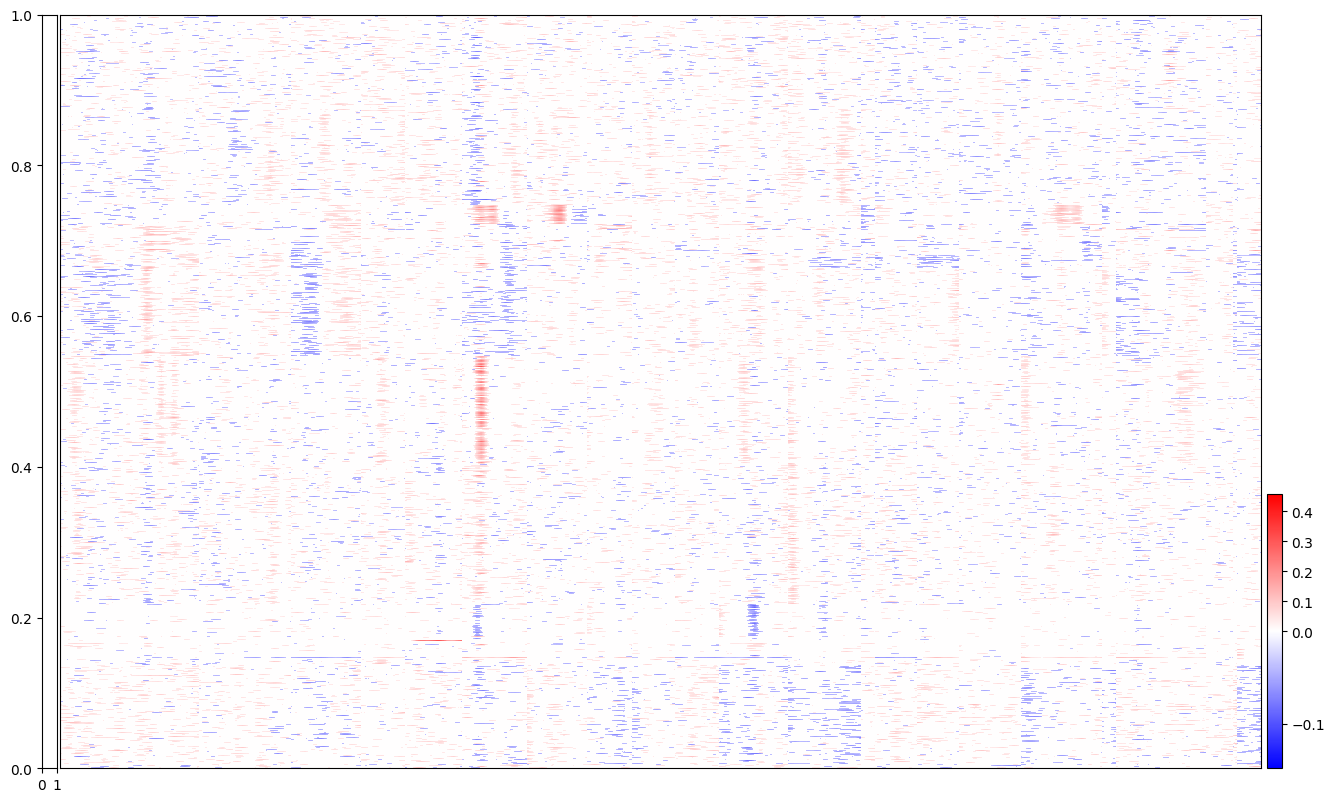

In [18]:
# Plotting a heatmap of copy number variations across chromosomes, grouped by cell type.
# This visualization will help in understanding the distribution of CNVs among different cell types.
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")


### Clustering by Copy Number Variation Profiles and Identifying Tumor Cells

### In this section, we will cluster the cells based on their copy number variation (CNV) profiles. This clustering will aid in the identification of tumor cells within the dataset.

In [20]:
# Performing Principal Component Analysis (PCA) on the copy number variation data to reduce dimensionality.
cnv.tl.pca(adata)

# Computing the neighborhood graph of cells based on the PCA results to prepare for clustering.
cnv.pp.neighbors(adata)

# Applying Leiden clustering algorithm to identify groups of cells based on their CNV profiles.
cnv.tl.leiden(adata, flavor="igraph", directed=False, n_iterations=2)



/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1863 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


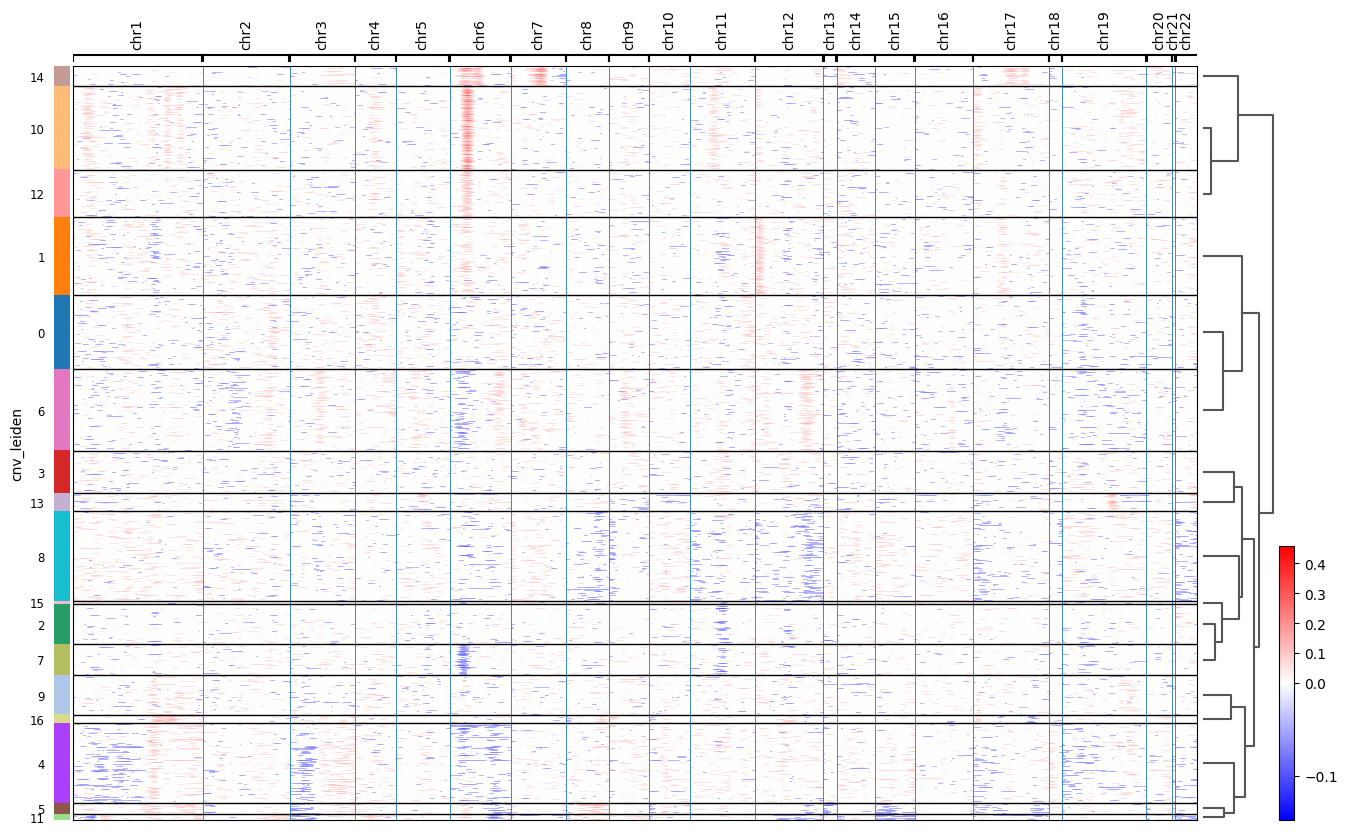

In [21]:
# Plotting a heatmap of copy number variations across chromosomes, grouped by the Leiden clustering results (cnv_leiden).
# The dendrogram is included to visualize the hierarchical relationships between clusters based on CNV profiles.
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)


## UMAP Visualization of Copy Number Variation Profiles

In [22]:
# Performing UMAP dimensionality reduction on the copy number variation data for visualization purposes.
cnv.tl.umap(adata)

# Calculating the CNV scores for each cell, which summarize the extent of copy number variations.
cnv.tl.cnv_score(adata)


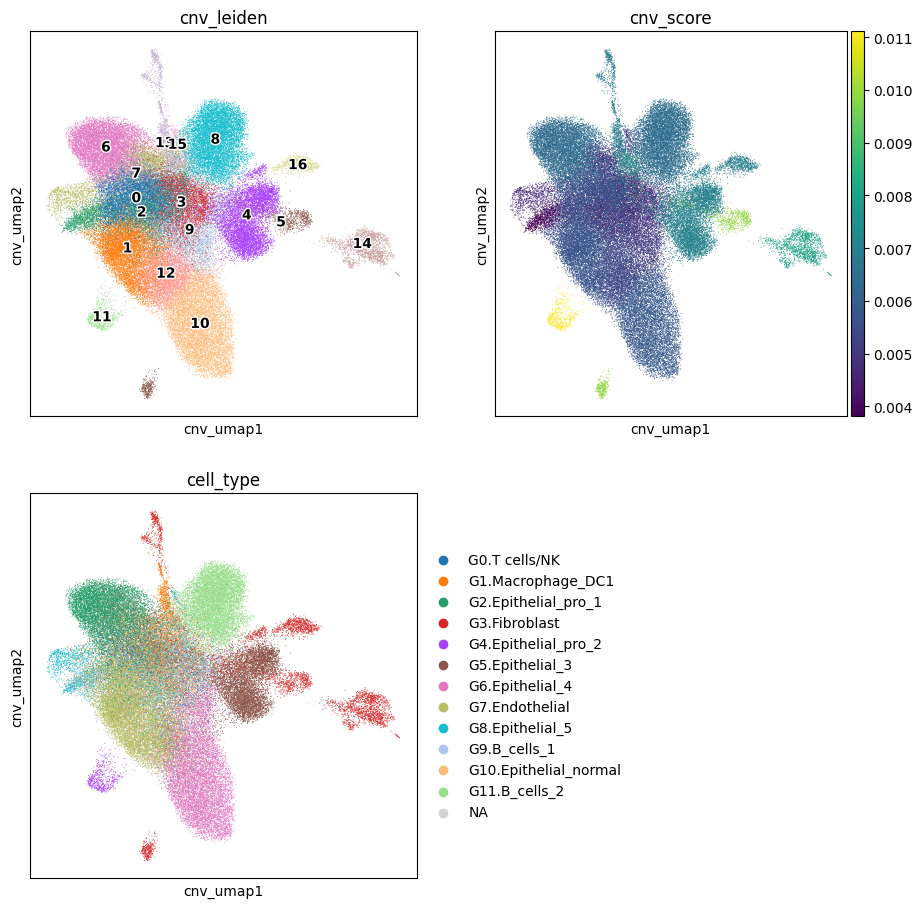

In [24]:
# Creating a 2x2 subplot layout for visualizing UMAP results, with a figure size of 11x11 inches.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))

# Turning off the fourth subplot (ax4) as it will not be used.
ax4.axis("off")

# Plotting UMAP visualization colored by the Leiden clustering results (cnv_leiden) on the first subplot (ax1).
# Legend is displayed on the data, with an outline of the font for better visibility.
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)

# Plotting UMAP visualization colored by CNV scores on the second subplot (ax2).
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)

# Plotting UMAP visualization colored by cell types on the third subplot (ax3).
cnv.pl.umap(adata, color="cell_type", ax=ax3)


## Visualizing CNV Scores and Clusters on Transcriptomics-Based UMAP

### We can also visualize the CNV scores and clusters on the UMAP plot based on transcriptomics data. Notably, there are subclusters of epithelial cells that belong to distinct CNV clusters, which tend to exhibit the highest CNV scores.

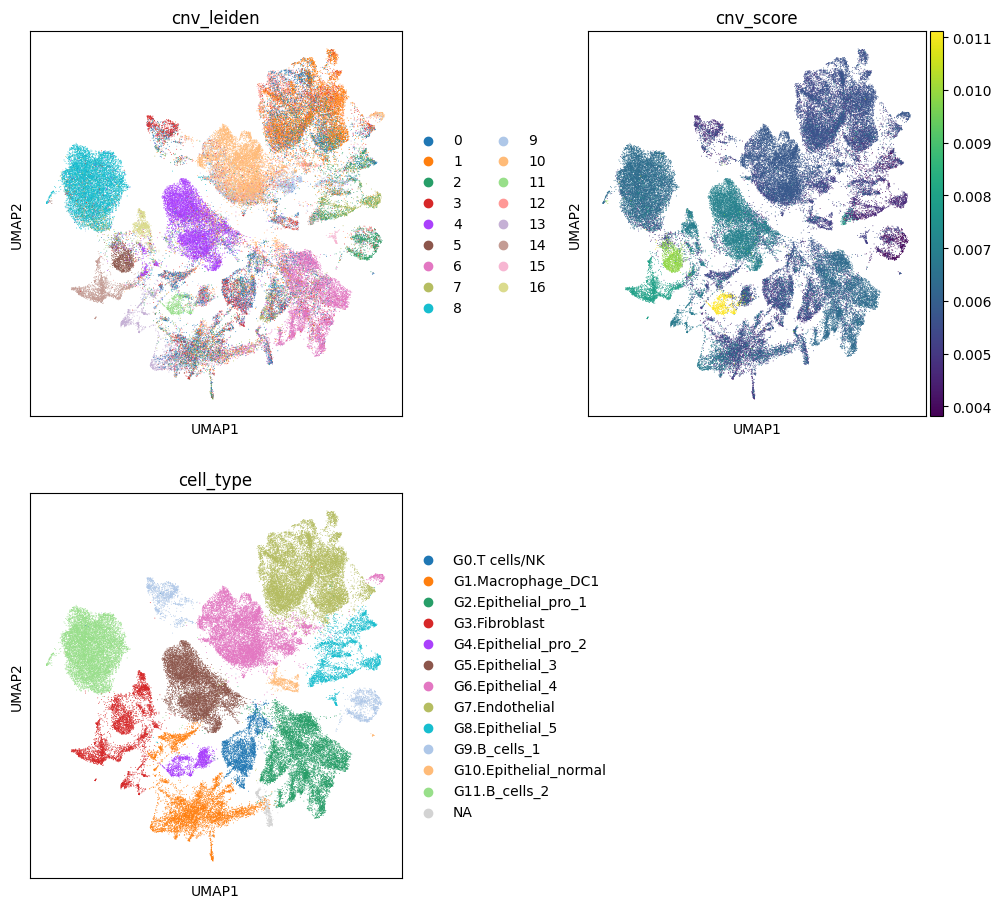

In [25]:
# Creating a 2x2 subplot layout for visualizing UMAP results, with a figure size of 12x11 inches and custom spacing.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})

# Turning off the fourth subplot (ax4) as it will not be used.
ax4.axis("off")

# Plotting UMAP visualization colored by the Leiden clustering results (cnv_leiden) on the first subplot (ax1).
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)

# Plotting UMAP visualization colored by CNV scores on the second subplot (ax2).
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)

# Plotting UMAP visualization colored by cell types on the third subplot (ax3).
sc.pl.umap(adata, color="cell_type", ax=ax3)


In [26]:
# Saving the updated AnnData object, which now includes CNV analysis results, to an .h5ad file for future use.
adata.write_h5ad(f'{base_data_path}/infer_cnv_completed.h5ad')
